In [1]:
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

import pandas as pd
import numpy as np
import datetime as dt
from collections import defaultdict
import time
import datetime as dt
from pytz import timezone
tz = timezone('EST')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

In [2]:
vt2011 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2011_smd_hourly.xls")
vt2011 = pd.read_excel(vt2011, 'VT')
vt2012 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2012_smd_hourly.xls")
vt2012 = pd.read_excel(vt2012, 'VT')
vt2013 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2013_smd_hourly.xls")
vt2013 = pd.read_excel(vt2013, 'VT')
vt2014 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2014_smd_hourly.xls")
vt2014 = pd.read_excel(vt2014, 'VT')
vt2015 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2015_smd_hourly.xls")
vt2015 = pd.read_excel(vt2015, 'VT')
vt2016 = pd.ExcelFile(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2016_smd_hourly.xls")
vt2016 = pd.read_excel(vt2016, 'VT')

In [3]:
vt2017 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2017_smd_hourly.xlsx", 'VT')
vt2018 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2018_smd_hourly.xlsx", 'VT')
vt2019 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2019_smd_hourly.xlsx", 'VT')
vt2020 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2020_smd_hourly.xlsx", 'VT')
vt2021 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2021_smd_hourly.xlsx", 'VT')
vt2022 = pd.read_excel(r"C:\Users\Rohan\Desktop\Big Data\Load Data\smd_hourly_2011_2022\2022_smd_hourly.xlsx", 'VT')

In [4]:
vt2022

,Date,Hr_End,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point
0,2022-01-01,1,572.4,531.140,32.20,32.35,-0.55,0.40,25.56,25.95,0.0,-0.39,36,35
1,2022-01-01,2,555.1,508.084,31.93,32.31,-0.68,0.30,25.54,25.87,0.0,-0.33,36,36
2,2022-01-01,3,496.6,490.019,31.01,30.85,0.00,0.16,27.41,27.50,0.0,-0.09,33,33
3,2022-01-01,4,480.6,483.029,29.82,29.69,0.00,0.13,25.07,25.13,0.0,-0.06,34,33
4,2022-01-01,5,481.5,485.721,31.04,30.86,0.00,0.18,29.20,29.27,0.0,-0.07,33,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2022-01-31,20,778.7,822.082,227.58,226.40,0.00,1.18,296.06,295.80,0.0,0.26,18,7
740,2022-01-31,21,705.3,793.781,204.16,202.82,0.00,1.34,265.22,264.21,0.0,1.01,17,7
741,2022-01-31,22,629.3,764.808,182.45,183.42,0.00,-0.97,252.46,251.93,0.0,0.53,15,6
742,2022-01-31,23,628.3,720.894,179.47,179.93,0.00,-0.46,191.26,190.96,0.0,0.30,14,6


In [5]:
val2011 = vt2011['DEMAND']
val2012 = vt2012['DEMAND']
val2013 = vt2013['DEMAND']
val2014 = vt2014['DEMAND']
val2015 = vt2015['DEMAND']
val2016 = vt2016['RT_Demand']
val2017 = vt2017['RT_Demand']
val2018 = vt2018['RT_Demand']
val2019 = vt2019['RT_Demand']
val2020 = vt2020['RT_Demand']
val2021 = vt2021['RT_Demand']
val2022 = vt2022['RT_Demand']

In [6]:
values = [val2011, val2012, val2013, val2014, val2015, val2016, val2017, val2018, val2019, val2020, val2021, val2022]
values_df = pd.concat(values, axis=0, ignore_index=False)
values_df = values_df.reset_index()
period = len(values_df)

In [7]:
rng = pd.date_range('2011-01-01', periods=period, freq='1H')
date_df = pd.DataFrame({ 'ds': rng})
date_df = date_df.reset_index()

In [8]:
frames = [date_df, values_df]
vt_load = pd.concat(frames, axis=1, ignore_index=False)
vt_load = vt_load.rename(columns={vt_load.columns[1]: 'ds', vt_load.columns[3]: 'y'})
frames2 = [vt_load['ds'], vt_load['y']]
vt_load = pd.concat(frames2, axis=1, ignore_index=False)
vt_load

,ds,y
0,2011-01-01 00:00:00,575.000
1,2011-01-01 01:00:00,540.000
2,2011-01-01 02:00:00,516.000
3,2011-01-01 03:00:00,505.000
4,2011-01-01 04:00:00,503.000
...,...,...
97171,2022-01-31 19:00:00,822.082
97172,2022-01-31 20:00:00,793.781
97173,2022-01-31 21:00:00,764.808
97174,2022-01-31 22:00:00,720.894


In [9]:
model = Prophet(
        changepoint_prior_scale=0.5, 
        seasonality_mode='multiplicative', 
        interval_width=0.95, 
    )
model.add_country_holidays(country_name='US')

In [10]:
model.fit(vt_load)

In [11]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('vt_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

# Forecasting

In [ ]:
with open('VT_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [12]:
future_pd = M.make_future_dataframe(
        periods=365, 
        freq='d',
        include_history=False
    )
    
# make predictions
forecast_pd = m.predict(future_pd)

In [13]:
forecast_pd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
97536,2022-02-16 00:00:00,586.604746,464.059339,705.877385
97537,2022-02-16 01:00:00,565.027689,449.643446,686.842067
97538,2022-02-16 02:00:00,551.093867,439.790277,682.002079
97539,2022-02-16 03:00:00,549.815510,439.336226,668.595869
97540,2022-02-16 04:00:00,567.513779,446.009518,681.057806


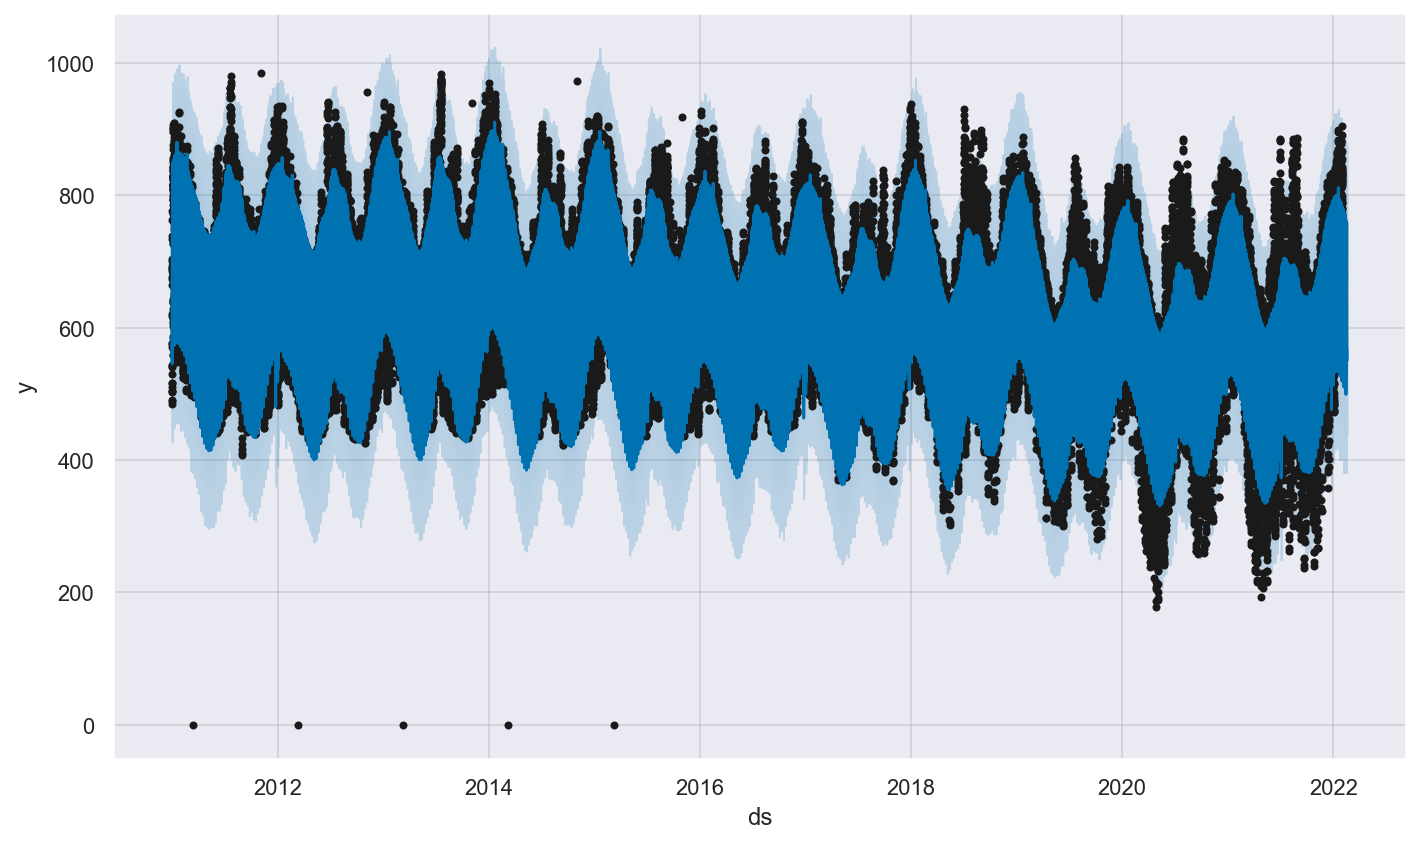

In [14]:
fig1 = model.plot(forecast_pd)

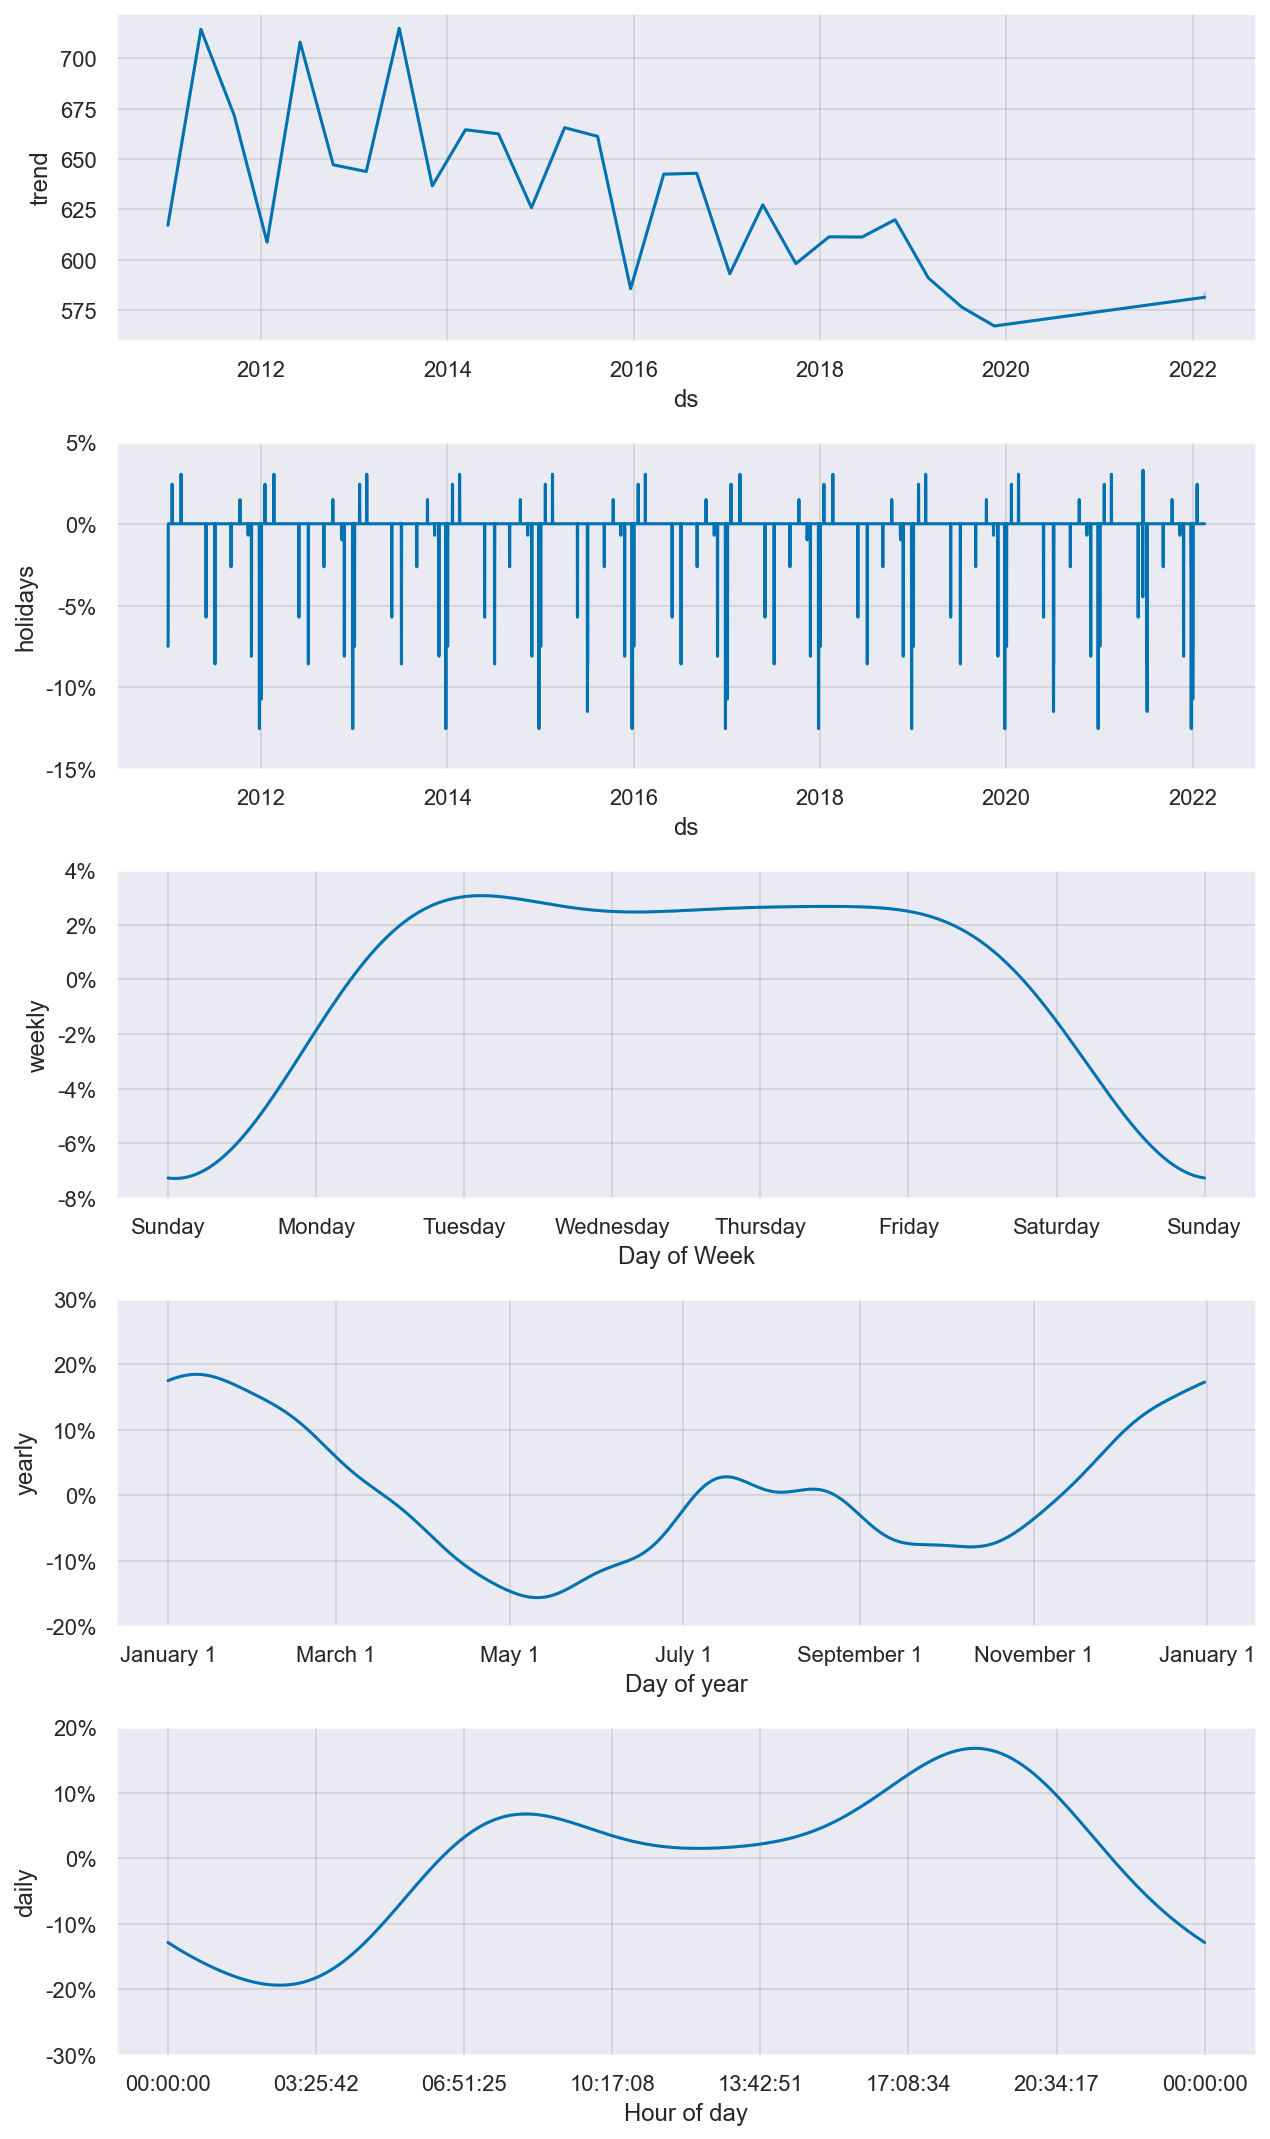

In [15]:
fig2 = model.plot_components(forecast_pd)

In [16]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01 00:00:00,617.098584,473.460785,709.866127,617.098584,617.098584,0.0,0.0,0.0,0.0,...,-0.015304,-0.015304,-0.015304,0.174109,0.174109,0.174109,0.0,0.0,0.0,589.475077
1,2011-01-01 01:00:00,617.129849,442.529954,682.274325,617.129849,617.129849,0.0,0.0,0.0,0.0,...,-0.018367,-0.018367,-0.018367,0.174183,0.174183,0.174183,0.0,0.0,0.0,564.905836
2,2011-01-01 02:00:00,617.161113,442.365300,660.811033,617.161113,617.161113,0.0,0.0,0.0,0.0,...,-0.021488,-0.021488,-0.021488,0.174256,0.174256,0.174256,0.0,0.0,0.0,548.392828
3,2011-01-01 03:00:00,617.192377,426.860550,662.217485,617.192377,617.192377,0.0,0.0,0.0,0.0,...,-0.024654,-0.024654,-0.024654,0.174330,0.174330,0.174330,0.0,0.0,0.0,545.267355
4,2011-01-01 04:00:00,617.223641,452.062979,673.028073,617.223641,617.223641,0.0,0.0,0.0,0.0,...,-0.027850,-0.027850,-0.027850,0.174403,0.174403,0.174403,0.0,0.0,0.0,562.252110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97536,2022-02-16 00:00:00,581.407820,464.059339,705.877385,580.495659,584.305426,0.0,0.0,0.0,0.0,...,0.024938,0.024938,0.024938,0.112754,0.112754,0.112754,0.0,0.0,0.0,586.604746
97537,2022-02-16 01:00:00,581.408541,449.643446,686.842067,580.475656,584.315153,0.0,0.0,0.0,0.0,...,0.024843,0.024843,0.024843,0.112607,0.112607,0.112607,0.0,0.0,0.0,565.027689
97538,2022-02-16 02:00:00,581.409262,439.790277,682.002079,580.455900,584.324880,0.0,0.0,0.0,0.0,...,0.024779,0.024779,0.024779,0.112459,0.112459,0.112459,0.0,0.0,0.0,551.093867
97539,2022-02-16 03:00:00,581.409982,439.336226,668.595869,580.436595,584.334608,0.0,0.0,0.0,0.0,...,0.024743,0.024743,0.024743,0.112312,0.112312,0.112312,0.0,0.0,0.0,549.815510


In [17]:
forecast_pd.to_csv('vt_forecast', index=False)

In [18]:
import joblib
 
# Save the model as a pickle in a file
joblib.dump(model, 'vt_model.pkl')

['vt_model.pkl']